                                                          UJIAN AKHIR SEMESTER PROYEK DATA SAINS DAN ANALISIS

Nama                  : Muhammad Raihan Dawwami & Muhammad Zidan Nugraha

NIM                   : 1519622064 & 1519622062

Prodi                 : Sistem dan Teknologi Informasi

Nama Dataset          :

Algoritma yang dipakai: Generative Stochastic Transformer (GST)

Tujuan Analisis       :

Generative Stochastic Transformer adalah Transformer yang tidak hanya memprediksi satu keluaran deterministik, tetapi memodelkan banyak kemungkinan keluaran menggunakan distribusi probabilitas. Mudahnya adalah "Model tidak bertanya “jawaban paling benar apa?”, tapi “jawaban apa saja yang mungkin, dan seberapa besar peluangnya?”

Disebut stochastic?

Karena:

- Output di-sample dari distribusi probabilitas
- Setiap generasi bisa berbeda, meskipun inputnya sama
- Cocok untuk data yang ambigu atau multimodal

# Install & Import Library

In [59]:
# BERIKAN KODE ANDA DISINI
# Install & Import Library
import matplotlib as plt
import torch
from torch import nn
import numpy
import pandas

SOAL 1: Tuliskan Fungsi Fungsi Library yang digunakan
1. pandas (pd) → digunakan untuk memanipulasi dan menganalisis data dalam bentuk tabel (DataFrame). (MISAL)
2.
3. dst


In [2]:
# BERIKAN KODE ANDA DISINI
# Tampilan dataframe yang lebih rapi

def create_sequences(data, input_len=24, pred_len=5):
    X, Y = [], []
    for i in range(len(data) - input_len - pred_len):
        X.append(data[i:i+input_len])
        Y.append(data[i+input_len:i+input_len+pred_len])
    return numpy.array(X), numpy.array(Y)


In [3]:
class Encoder(nn.Module):
    def __init__(self, d_model=64, nhead=4):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        return self.encoder(x).mean(dim=0)

In [4]:
class LatentLayer(nn.Module):
    def __init__(self, d_model=64, latent_dim=16):
        super().__init__()
        self.mu = nn.Linear(d_model, latent_dim)
        self.logvar = nn.Linear(d_model, latent_dim)

    def forward(self, h):
        mu = self.mu(h)
        logvar = self.logvar(h)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar


In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=16, d_model=64, pred_len=5):
        super().__init__()
        self.fc = nn.Linear(latent_dim, d_model)
        self.output = nn.Linear(d_model, pred_len)

    def forward(self, z):
        h = self.fc(z)
        return self.output(h)


In [6]:
class GST(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.latent = LatentLayer()
        self.decoder = Decoder()

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.latent(h)
        y_hat = self.decoder(z)
        return y_hat, mu, logvar


# Membaca Dataset

SOAL 2. Berikan deskripsi tentang dataset

Jawaban:
Jumlah Dataset:
Jenis Dataset:


In [68]:
# BERIKAN KODE ANDA DISINI
# 1. Load Dataset dari Google Drive / Colab Files
data = pandas.read_csv("employment-data.csv")

cols_needed = [
    "ref_area.label",
    "time",
    "classif1.label",
    "classif2.label",
    "obs_value"
]

df = data[cols_needed].copy()


def map_sector(label):
    if "Economic activity (Broad sector): Agriculture" in label:
        return "agriculture"
    elif "Economic activity (Broad sector): Industry" in label:
        return "industry"
    elif "Economic activity (Broad sector): Services" in label:
        return "services"
    elif "Economic activity (Broad sector): Non-agriculture" in label:
        return "non_agriculture"
    else:
        return None
    
def map_skill(label):
    if "Occupation (Skill level): Skill level 1 ~ low" in label:
        return "skill_1"
    elif "Occupation (Skill level): Skill level 2 ~ medium" in label:
        return "skill_2"
    elif "Occupation (Skill level): Skill levels 3 and 4 ~ high" in label:
        return "skill_3_4"
    else:
        return None

df["skill"] = df["classif2.label"].apply(map_skill)
df["sector"] = df["classif1.label"].apply(map_sector)



    
df_clean = df.dropna(subset=["sector", "skill"])
df_clean["time"] = pandas.to_datetime(df_clean["time"], format="%Y")

df_table = (
    df_clean
    .groupby(
        ["ref_area.label", "time", "sector", "skill"],
        as_index=False
    )["obs_value"]
    .sum()
)
df_table.rename(columns={"ref_area.label": "country", "obs_value": "value", "obs_value": "employment"}, inplace=True)


#df_table.groupby("sector")["value"].describe()
df_table.groupby(["sector", "skill"])["time"].nunique()






sector           skill    
agriculture      skill_1      10
                 skill_2      10
                 skill_3_4    10
industry         skill_1      10
                 skill_2      10
                 skill_3_4    10
non_agriculture  skill_1      10
                 skill_2      10
                 skill_3_4    10
services         skill_1      10
                 skill_2      10
                 skill_3_4    10
Name: time, dtype: int64

In [ ]:
df_agg = (
    df.groupby(
        ["country", "time", "sector", "skill"]
    )["employment"]
     .sum()
     .reset_index()
)

country = "Afghanistan"

df_c = df_agg[df_agg["country"] == country]

df_ts = df_c.pivot_table(
    index="time",
    columns=["sector", "skill"],
    values="employment"
).sort_index()

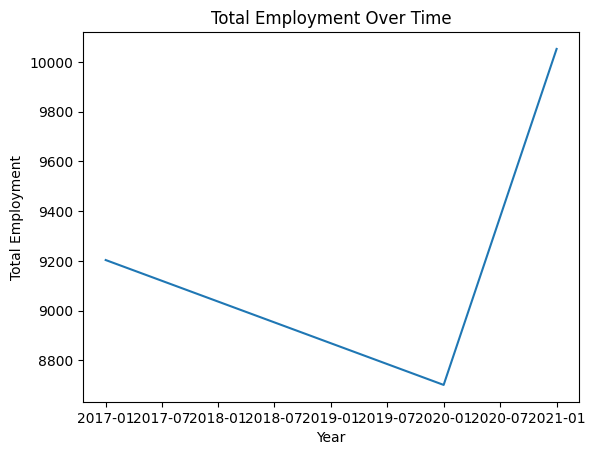

In [70]:
country = "Afghanistan"
df_c = df_table[df_table["country"] == country]

total_by_year = (
    df_c.groupby("time")["employment"]
      .sum()
      .reset_index()
)

plt.pyplot.figure()
plt.pyplot.plot(total_by_year["time"], total_by_year["employment"])
plt.pyplot.xlabel("Year")
plt.pyplot.ylabel("Total Employment")
plt.pyplot.title("Total Employment Over Time")
plt.pyplot.show()

Berikan defenisi fitur/variabel anda disini

SOAL 3. Berikan penjelasan tentang Exploratory Data Analisis yang dilakukan (semakin lengkap dan detail semakin tinggi poin-nya)

Jawaban:

In [ ]:
# Visualisasi Contoh


Berikan keterangan setiap visualisasi data yang dibuat

Gambar di atas merupakan grafik tren ....

In [ ]:
# Visualisasi 2




Berikan keterangan setiap visualisasi data yang dibuat

Gambar di atas merupakan grafik tren ....


In [ ]:
# Dan seterusnya jika dirasa masih ada yang perlu ditampilkan

# Preprocessing Data

SOAL 4. Berikan deskripsi data pre-processing yang dilakukan

1.

2.

3.

4.

dst

In [ ]:
# Kode Data Cleaning 1

In [ ]:
# Cek Duplikat... dst


In [ ]:
# Data transform ... dst

In [ ]:
# Simpan dataset yang sudah bersih



# Feature Engineering & Data Augmentasi

SOAL 5. Defenisikan Feature engineering  dan Data Augmentasi


-- Strategi Desain GST untuk Dataset Kecil
Shallow Transformer (2–4 layers),
Latent dimension kecil (z ≤ 16), dan
Sequence-level latent (bukan token-level)

3.2 Data Augmentation / Synthetic Data dengan menggunakan:
Augmentasi domain-spesifik
Pre-generate synthetic samples



In [ ]:
# Feature engineering: lags, rolling


In [ ]:
# Kode Lain lain

# Data Splitting

SOAL 6. Apa itu Data splitting mengapa harus displitting?

Berikan keterangan tentang hasil data splitting yang dilakukan

In [ ]:
# Masukan kode data splitting

# Modelling

--
--
SOAL 7. Tuliskan tentang algoritma yang dipilih disini dan karakteristiknya

Jawaban:

SOAL 8. Apakah Jenis dataset sesuai dengan karakteristik algoritma yang dipilih?

Jawaban:

--
---

In [ ]:
# Masukan kode

In [ ]:
# ...
# ..

In [ ]:
# Train model dengan early stopping

In [ ]:
# Prediksi


# Evaluasi

Soal 9. Tuliskan evaluasi apasaja yang dilakukan semakin lengkap semakin baik (minimal 6 jenis evaluasi)

----- Evaluasi GST biasanya menggunakan----

Log-likelihood / ELBO

Diversity metrics

CRPS, NLL (forecasting)

Multiple-sample evaluation

Task-specific metrics (FID, SSIM untuk gambar)

In [ ]:
# kode evaluasi

Keterangan hasil evaluasi

# Forecasting

In [ ]:

# Prediksi / forecasting code (jika ada)


In [ ]:
# Simpan Output


10. keterangan hasil prediksi

# Kesimpulan

Soal 11. HASIL KESIMPULAN

Berdasarkan hasil evaluasi ......